# 0. Install Dependencies and Bring in Data

In [23]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Rohit94\AppData\Local\Temp\pip-install-1vz8gpw0\tensorflow-gpu_ae299225f2b94ed7af5aa21c8480ce5c\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did n

In [24]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [25]:
df = pd.read_csv(os.path.join(r'C:\Users\Rohit94\Downloads\CommentToxicity-main\CommentToxicity-main\jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [26]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [28]:
df.shape

(159571, 8)

In [29]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [30]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [31]:
from tensorflow.keras.layers import TextVectorization

In [32]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv=TfidfVectorizer(use_idf=True,ngram_range=(2,2))

In [34]:
train_features=cv.fit(X)
train_features=cv.transform(X)


In [35]:
train_features

<159571x2277365 sparse matrix of type '<class 'numpy.float64'>'
	with 9395775 stored elements in Compressed Sparse Row format>

In [36]:
MAX_FEATURES = 200000 # number of words in the vocab

In [37]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [38]:
vectorizer.adapt(X.values)

In [39]:
vectorized_text = vectorizer(X.values)

In [40]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [41]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [43]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [44]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
history = model.fit(train, epochs=5, validation_data=val,metric=['acc'])

6981/6981 [==============================] - 5105s 730ms/step - loss: 0.0648 - val_loss: 0.0451


In [19]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

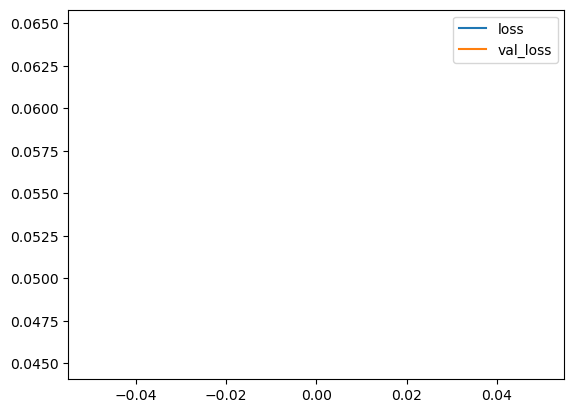

In [20]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [46]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [26]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 1s 567ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [29]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [30]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 157ms/step


In [31]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8712091445922852, Recall:0.6037117838859558, Accuracy:0.4824473559856415


In [32]:
!pip install gradio jinja2

In [18]:
import tensorflow as tf
import gradio as gr

In [34]:
model.save('toxicity.h5')

In [18]:
model = tf.keras.models.load_model('toxicity.h5')

In [19]:
model.load_weights('toxicity.h5')

In [20]:
input_str = vectorizer('stupid i really hate you')

In [21]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 2s 2s/step


In [22]:
res

array([[0.94636816, 0.0707555 , 0.7553783 , 0.02402725, 0.5635473 ,
        0.08147844]], dtype=float32)

In [30]:
res[0][0]

0.94636816

In [26]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
res = model.predict(np.expand_dims(input_text,0))
res

1/1 [==============================] - 0s 131ms/step


array([[0.9870054 , 0.15102614, 0.90043277, 0.02022694, 0.7439138 ,
        0.10616712]], dtype=float32)

In [25]:
input_text = vectorizer('i love u')
res = model.predict(np.expand_dims(input_text,0))
res

1/1 [==============================] - 0s 150ms/step


array([[0.13745576, 0.00093848, 0.02424281, 0.00444117, 0.03239569,
        0.01066806]], dtype=float32)

In [27]:
input_text = vectorizer('FUCK YOUR FILTHY MOTHER IN THE ASS,DRY!')
res = model.predict(np.expand_dims(input_text,0))
res

1/1 [==============================] - 0s 83ms/step


array([[0.99753535, 0.39840356, 0.96396726, 0.02130314, 0.8942348 ,
        0.15099531]], dtype=float32)

In [34]:
a=0 if res[0][5]<0.5 else 1
a

0